# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.63KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

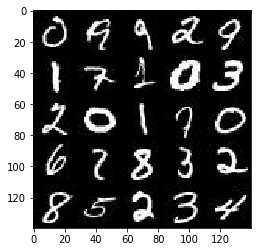

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

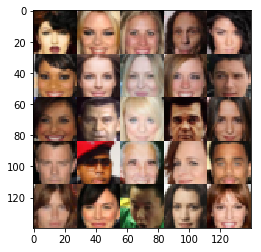

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [4]:
mnist_images.shape

(25, 28, 28, 3)

In [5]:
mnist_images.shape[-3:]

(28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    #input dim will be that of generator output dim, i.e, 28x28xout_chan_dim(3)
    with tf.variable_scope('discriminator', reuse=reuse):
        #conv layer1
        x1 = tf.layers.conv2d(images,64, (5,5), strides=(2,2), padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 14x14x64
        
        #conv layer2
        x2 = tf.layers.conv2d(relu1, 128, (5,5), strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
         #conv layer3
        x3 = tf.layers.conv2d(relu2, 256, (5,5), strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        #flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Input
        x1 = tf.layers.dense(z, 7*7*128)
        # reshape it 
        reshaped1 = tf.reshape(x1, (-1,7,7,128))
        bn1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x128 is the output
        
        x2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x64
        
        x3 = tf.layers.conv2d_transpose(relu2, 32, 5, strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x32
        
        #logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=(1,1), padding='same')
        # should be 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_out = generator(z=input_z, out_channel_dim=out_channel_dim, is_train=True)
    discriminator_out_real, discriminator_logits_real = discriminator(images=input_real, reuse=False)
    discriminator_out_z, discriminator_logits_z = discriminator(images = generator_out, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_out_real)))
    
    discriminator_loss_z = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels = tf.zeros_like(discriminator_out_z)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels=tf.ones_like(discriminator_out_z)))
    
    discriminator_loss_total = discriminator_loss_real + discriminator_loss_z
    
    return discriminator_loss_total, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_variables = tf.trainable_variables()
    discriminator_variables = [var for var in t_variables if var.name.startswith('discriminator')]
    generator_variables = [var for var in t_variables if var.name.startswith('generator')]
    
    #optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
        generator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    losses = []
    steps = 0
    print_every=10
    show_every=100
    
    image_width, image_height, image_channel_depth  = data_shape[-3:]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channel_depth, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z,out_channel_dim=image_channel_depth)
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr, beta1=beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                #random noise sample
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                #running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                #print stats
                if steps % print_every ==0:
                    disc_loss_train = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    gen_loss_train = gen_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(disc_loss_train),
                          "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                    losses.append((disc_loss_train, gen_loss_train))
                    
                #show images
                if steps% show_every ==0:
                    show_generator_output(sess, 16, input_z, image_channel_depth, data_image_mode)
        
        #each epoch
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.1045... Generator Loss: 16.6891
Epoch 1/2... Discriminator Loss: 2.6827... Generator Loss: 3.4717
Epoch 1/2... Discriminator Loss: 1.5481... Generator Loss: 1.8523
Epoch 1/2... Discriminator Loss: 2.0104... Generator Loss: 2.3153
Epoch 1/2... Discriminator Loss: 1.8986... Generator Loss: 2.0039
Epoch 1/2... Discriminator Loss: 1.7315... Generator Loss: 2.0365
Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 1.8182
Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 1.8055
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 1.8369
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 1.9102


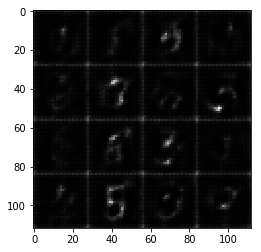

Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 2.0820
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 2.2057
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.9375
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 2.3673
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 2.4326
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 2.3703
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 2.4759
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 3.4344
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 3.3552
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 1.8890


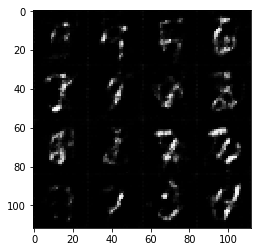

Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 2.5560
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 2.9041
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 3.1951
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 2.4628
Epoch 1/2... Discriminator Loss: 1.9052... Generator Loss: 4.6306
Epoch 1/2... Discriminator Loss: 0.5986... Generator Loss: 2.4236
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 4.3901
Epoch 1/2... Discriminator Loss: 1.9223... Generator Loss: 3.2871
Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 4.6988
Epoch 1/2... Discriminator Loss: 0.1537... Generator Loss: 2.3887


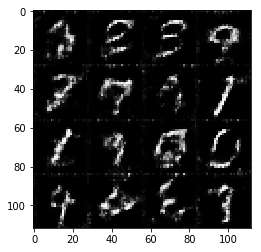

Epoch 1/2... Discriminator Loss: 0.1148... Generator Loss: 2.5355
Epoch 1/2... Discriminator Loss: 0.0224... Generator Loss: 5.0982
Epoch 1/2... Discriminator Loss: 0.0535... Generator Loss: 3.2222
Epoch 1/2... Discriminator Loss: 0.0208... Generator Loss: 4.4442
Epoch 1/2... Discriminator Loss: 0.0941... Generator Loss: 2.7683
Epoch 1/2... Discriminator Loss: 0.0090... Generator Loss: 6.1635
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.4298


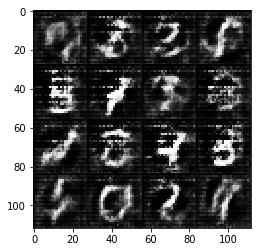

Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.3509
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.3401
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.3014
Epoch 1/2... Discriminator Loss: 1.6356... Generator Loss: 0.2888
Epoch 1/2... Discriminator Loss: 2.2648... Generator Loss: 0.1299
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 0.3108
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.3187
Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.5160... Generator Loss: 0.3053


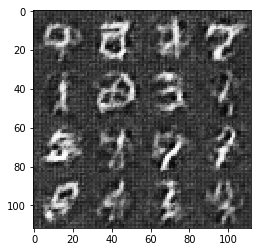

Epoch 2/2... Discriminator Loss: 0.2251... Generator Loss: 2.1804
Epoch 2/2... Discriminator Loss: 2.1574... Generator Loss: 4.8324
Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 1.6909
Epoch 2/2... Discriminator Loss: 0.0763... Generator Loss: 3.9825
Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 1.7339... Generator Loss: 2.1737
Epoch 2/2... Discriminator Loss: 0.1342... Generator Loss: 3.6588
Epoch 2/2... Discriminator Loss: 0.1003... Generator Loss: 2.9647
Epoch 2/2... Discriminator Loss: 0.0822... Generator Loss: 2.9040
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.4637


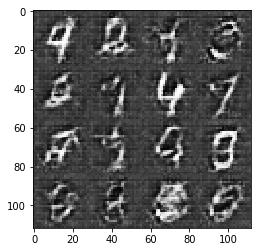

Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.4697
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 0.3282
Epoch 2/2... Discriminator Loss: 1.7212... Generator Loss: 0.2431
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.4095
Epoch 2/2... Discriminator Loss: 0.4849... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 2.0902... Generator Loss: 2.0733
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 2.8869
Epoch 2/2... Discriminator Loss: 0.1243... Generator Loss: 3.2204
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 1.1848
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 2.4811


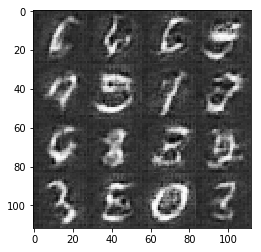

Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 3.1687
Epoch 2/2... Discriminator Loss: 0.3022... Generator Loss: 1.8790
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 3.0510
Epoch 2/2... Discriminator Loss: 2.0020... Generator Loss: 0.1852
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 0.1697... Generator Loss: 2.4516
Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 3.0807
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 0.3392
Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.2880


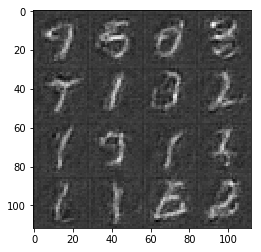

Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.7855... Generator Loss: 0.2626
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 0.1203... Generator Loss: 3.3080
Epoch 2/2... Discriminator Loss: 0.1491... Generator Loss: 2.3717
Epoch 2/2... Discriminator Loss: 0.2128... Generator Loss: 2.0189
Epoch 2/2... Discriminator Loss: 0.0531... Generator Loss: 4.0268
Epoch 2/2... Discriminator Loss: 0.1082... Generator Loss: 2.6062
Epoch 2/2... Discriminator Loss: 0.0669... Generator Loss: 3.2101


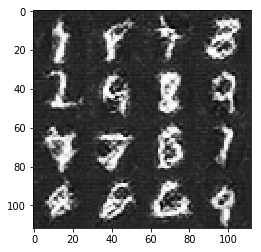

Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 4.8907
Epoch 2/2... Discriminator Loss: 0.0596... Generator Loss: 3.1860
Epoch 2/2... Discriminator Loss: 0.1161... Generator Loss: 5.4390


In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6709... Generator Loss: 8.1829
Epoch 1/1... Discriminator Loss: 1.7928... Generator Loss: 3.3506
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.3832
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 3.4919
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.9494
Epoch 1/1... Discriminator Loss: 3.4931... Generator Loss: 4.2362
Epoch 1/1... Discriminator Loss: 3.3128... Generator Loss: 5.0431
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.6786


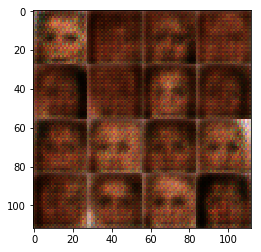

Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 2.1628... Generator Loss: 3.1260
Epoch 1/1... Discriminator Loss: 2.0709... Generator Loss: 2.8358
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 2.0352
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8725


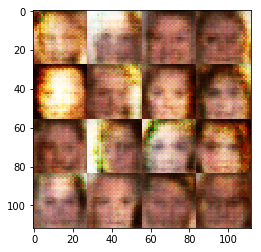

Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 0.2882... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.4459
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.9840


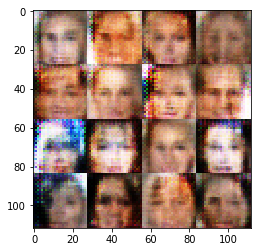

Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 2.4712
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 2.1342
Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 3.0528
Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 2.7015
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.2604
Epoch 1/1... Discriminator Loss: 0.0646... Generator Loss: 3.1296
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 3.4912
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 3.4101
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 4.5733


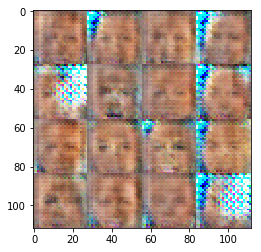

Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 4.0269
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 3.4086
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 5.1707
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.6289
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.0697
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 2.3743
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 1.7622
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.9255


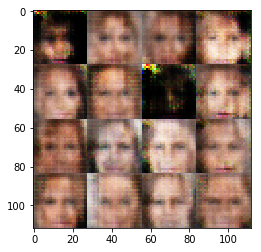

Epoch 1/1... Discriminator Loss: 3.6561... Generator Loss: 4.1748
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.2515
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.5048


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.